# LDA Using Fisher's Discriminant

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df1 = pd.read_csv('./a1_data/a1_d1.csv', header=None)
df2 = pd.read_csv('./a1_data/a1_d2.csv', header=None)
print(df1.head())
print(df2.head())

          0         1  2
0 -0.598283  1.023534  1
1  1.115929  0.512127  1
2  1.169815 -1.072747  0
3  0.631926 -0.255663  0
4  0.052532  1.198445  1
          0         1         2  3
0 -6.672418 -1.206198 -1.081050  0
1  1.675598  0.614994 -0.971600  0
2 -4.039058  0.335102  0.544618  1
3  0.793526 -0.235277  0.551771  1
4  3.820273 -0.274691  0.454743  1


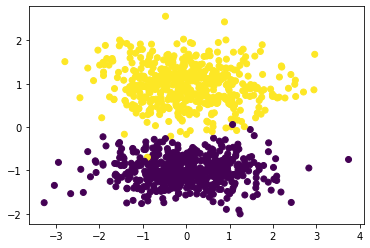

In [3]:
p = plt.scatter(df1[0], df1[1], c=df1[2])

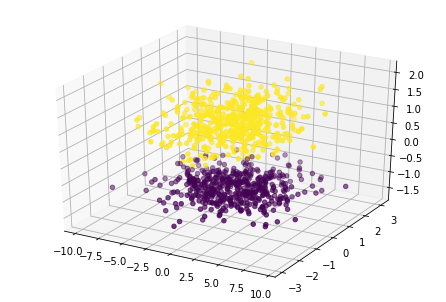

In [4]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(df2[0], df2[1], df2[2], c=df2[3])

### Helper Functions
`scale`: Implements standardisation over each of the dataset's columns

`solve`: Finds the x-coordinate of the intersection points of two given normal functions

`normal`: This is the pdf of the normal distribution

In [5]:
def scale(df):
    dim = len(df.columns)-1
    for i in range(0, dim):
        a = df[i].values
        a = (a-np.mean(a))/np.std(a)
        df[i] = a
    
    if dim == 2:
        df.columns = ['A', 'B', 'C']
    else:
        df.columns = ['A', 'B', 'D', 'C']
    
def solve(m1,m2,std1,std2):
    a = 1/(2*std1**2) - 1/(2*std2**2)
    b = m2/(std2**2) - m1/(std1**2)
    c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1)
    return np.roots([a,b,c])

def normal(x, mean, std):
    return (1/(np.sqrt(2*np.pi)*std))*np.exp(-1*((x-mean)**2/(2*std**2)))

### Steps to calculate the threshold point
- Find the means of the two classes $\mu_1, \mu_2$
- Find the within class variance $S_w$
- Find the transformation vector $w$ as $S_w(\mu_2-\mu_1)$
- Unit vectorize $w$
- Transform the data into 1D
- Find the intersection points of the two normal distributions representing the two classes
- Set it as the threshold

In [6]:
class Fisher_LDA:
    """
    This class implements the Fisher's Linear Discriminant
    
    Transforms the data into 1D
    then finds the intersection point of the two normal distribution and sets it as the 
    discriminant point
    """
    
    def __init__(self, df):
        """
        Default constructor
        
        requires a scaled dataframe as a parameter
        """
        
        self.df = df
        self.dim = self.df.shape[1] - 1
    
    def fit(self):
        """
        Finds the transformation vector `w` which transforms the dataset into 1D
        
        requires no parameters
        """
        
        # rdf0 and rdf1 contain points of class 0 and class 1 resp.
        rdf0 = pd.DataFrame()
        rdf1 = pd.DataFrame()
        for i, row in self.df.iterrows():
            if(row['C'] == 0):
                rdf0 = rdf0.append(row, ignore_index=True)
            else:
                rdf1 = rdf1.append(row, ignore_index=True)
        
        # Drop the class labels since the info is redundant
        rdf1 = rdf1.drop(['C'], axis=1)
        rdf0 = rdf0.drop(['C'], axis=1)

        mu0 = np.mean(rdf0).values
        mu1 = np.mean(rdf1).values
        
        # Convert the pd dataframes into numpy arrays
        rdf0 = rdf0.values
        rdf1 = rdf1.values
        
        # Set the dimension of the dataset
        dim = self.df.shape[1] - 1
        
        # Find the within class variance sw
        sw = [0, 0]
        for i in range(0, len(rdf0)):
            x = (rdf0[i]-mu0)
            y = (rdf1[i]-mu1)

            x.shape = (dim,1)
            y.shape = (dim,1)
            sw[0] += x.dot(x.T)
            sw[1] += y.dot(y.T)
        sw = sw[0] + sw[1]

        m = mu1-mu0
        
        # w is directly proportional to (mu2-mu1)*sw
        w = np.linalg.inv(sw)@m
        
        # unit vectorize w to remove the proportionality constant
        mag = np.sqrt(w.dot(w))
        self.w = w/(mag)

    def transform(self):
        """
        Converts the data into 1D
        """
        
        self.one_d_df = []
        self.nlist0 = []
        self.nlist1 = []
        for i, row in self.df.iterrows():
            a = (row[:self.dim].values).dot(self.w)
            self.one_d_df.append(a)
            if(row['C'] == 0):
                self.nlist0.append(a)
            else:
                self.nlist1.append(a)
        return self.one_d_df, self.nlist0, self.nlist1
    
    def plot(self):
        """
        Plots the 1D data as well as the separate normal distributions of the classes
        
        The normal distributions are plotted between 3 standard deviations of
        the minimum mean and the maximum mean where the standard deviation is the maximum of the available deviations
        """
        
        self.mean0 = np.mean(self.nlist0)
        self.mean1 = np.mean(self.nlist1)
        self.std0 = np.std(self.nlist0)
        self.std1 = np.std(self.nlist1)

        y = [0 for i in range(0, 1000)]
        plt.scatter(self.one_d_df, y, c=self.df['C'].values)
        if self.dim == 2:
            plt.savefig('./plots/2D.png', bbox_inches='tight')
        else:
            plt.savefig('./plots/3D.png', bbox_inches='tight')
        plt.show()
        plt.close()
    
        std = max(self.std0, self.std1)
        mn1 = min(self.mean0, self.mean1)
        mn2 = max(self.mean0, self.mean1)
        x = np.arange(mn1-3*std, mn2+3*std, 0.01)
        plt.plot(x, normal(x, self.mean0, self.std0))
        plt.plot(x, normal(x, self.mean1, self.std1))
        if self.dim == 2:
            plt.savefig('./plots/2D_normal.png', bbox_inches='tight')
        else:
            plt.savefig('./plots/3D_normal.png', bbox_inches='tight')
        plt.show()
        plt.close()
    
    def find_thresh(self):
        """
        Finds the threshold
        
        Solves the normal equations and sets the x coordinate as the
        solution which is in between the two means
        """
        
        self.thresh = 0
        r = solve(self.mean0, self.mean1, self.std0, self.std1)
        if r[0] < max(self.mean0, self.mean1) and r[0] > min(self.mean0, self.mean1):
            self.thresh = r[0]
        else:
            self.thresh = r[1]

        return self.thresh
    
    def test_accuracy(self):
        """
        Finds the no. of misclassified points and the accuracy
        Also finds the F-score and the confusion matrix
        """
        
        dim = self.df.shape[1] - 1
        test = []
        confusion_matrix = [[0, 0], [0, 0]]
        for i, row in self.df.iterrows():
            if row[:self.dim].dot(self.w) > self.thresh:
                test.append(1)
            else:
                test.append(0)
        err = 0
        for i in range(0, len(self.df['C'])):
            if test[i] != self.df['C'][i]:
                err+=1
            confusion_matrix[int(self.df['C'][i])][test[i]] += 1
        
        precision = confusion_matrix[0][0]/(confusion_matrix[0][0]+confusion_matrix[1][0])
        recall = confusion_matrix[0][0]/(confusion_matrix[0][0]+confusion_matrix[0][1])
        f_score = (2*precision*recall)/(precision+recall)
        accuracy = (confusion_matrix[0][0]+confusion_matrix[1][1])/np.sum(confusion_matrix)
        
        print("Threshold point:", self.thresh)
        print("No. of misclassified points:", err)
        print("Percent accuracy:", accuracy*100, '%')
        print("F-Score:", f_score)
        print("Confusion Matrix")
        print(confusion_matrix)

In [7]:
scale(df1)
scale(df2)

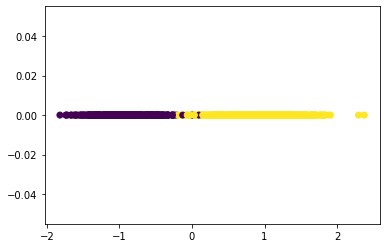

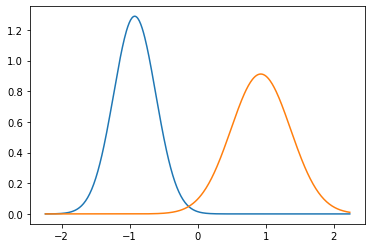

Threshold point: -0.13328610589766562
No. of misclassified points: 7
Percent accuracy: 99.3 %
F-Score: 0.993006993006993
Confusion Matrix
[[497, 3], [4, 496]]


In [8]:
fisher = Fisher_LDA(df1)
fisher.fit()
fisher.transform()
fisher.plot()
fisher.find_thresh()
fisher.test_accuracy()

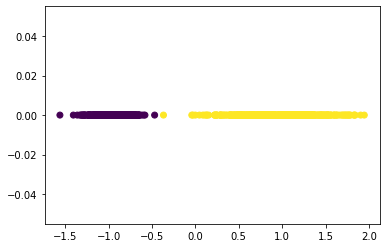

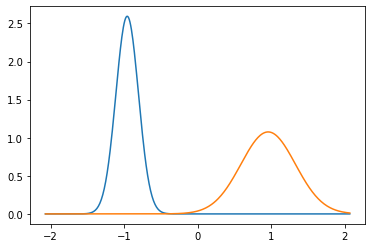

Threshold point: -0.3707808853290484
No. of misclassified points: 0
Percent accuracy: 100.0 %
F-Score: 1.0
Confusion Matrix
[[500, 0], [0, 500]]


In [9]:
fisher = Fisher_LDA(df2)
fisher.fit()
fisher.transform()
fisher.plot()
fisher.find_thresh()
fisher.test_accuracy()